# Bs Spectroscopy analysis
This is a simplified version of the analysis described in [LHCb-PAPER-2020-026](https://lhcbproject.web.cern.ch/Publications/l/LHCb-PAPER-2020-026.html)

The analysis is limited to the histogram corresponding to the highest pt bin (Fig 1f of the paper)

In [1]:
.L ../data/RooRelBreitWigner.cpp+


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:
using namespace RooFit;

In [3]:
TFile* f=new TFile("../data/bsHistogram.root");
TH1* h=(TH1*) f->Get("hdata");

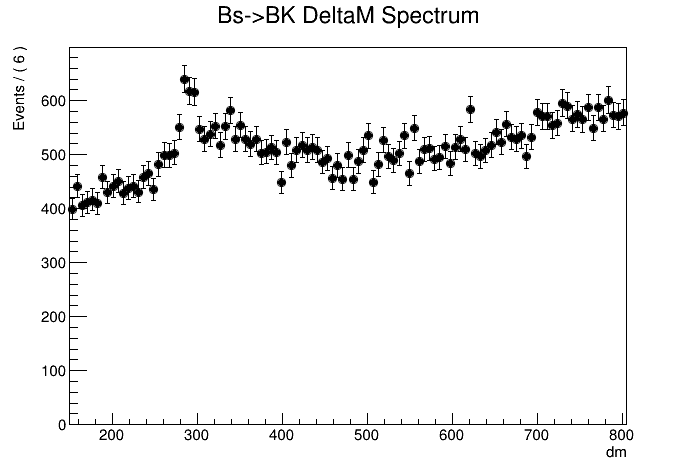

In [4]:
RooRealVar dm("dm", "dm", h->GetXaxis()->GetXmin(),  h->GetXaxis()->GetXmax());
RooDataHist mydata("data", "data", dm, Import(*h));
RooPlot *frame = dm.frame(Title("Bs->BK DeltaM Spectrum"));
mydata.plotOn(frame);

TCanvas* mycanvas= new TCanvas();
frame->Draw();
mycanvas->Draw();

In [5]:
  // fixed combinatorial background from same sign candidates
  RooGenericPdf   pdfss("pdfss","Comb Bkg","pow(@0,1.21953)*exp(-0.000297966*@0)",RooArgList(dm));
  
  // Associated production background, modeled with second degree polynomial
  RooRealVar c0("c0","c0",-0.5,-1,1);
  RooRealVar c1("c1","c1",0,-1,1);
  RooChebychev pdfap("pdfap","Ass. prod Bkg",dm,RooArgList(c0,c1));

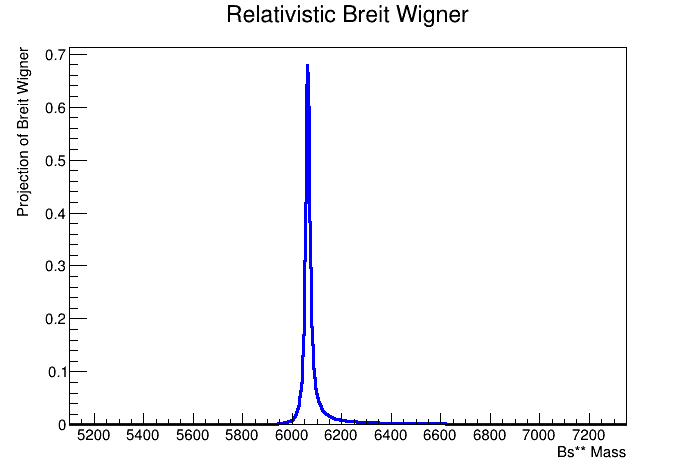

[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw_Int[Mass]) using numeric integrator RooIntegrator1D to calculate Int(Mass)


In [6]:
  // Rel. Breit Wigner model for signal
  RooRealVar mk("mk","mK",493.677);
  RooRealVar mb("mb","mB",5279.29);
  RooRealVar radius("radius","radius",4e-3);
  RooRealVar spin("spin","spin",3);
  RooRealVar mbump("mbump","mbump",290,280,320);
  RooRealVar wbump("wbump","wbump",20,5,150);
  RooFormulaVar mabs( "mabs", "mabs", "dm + mb + mk", RooArgList( dm, mb, mk) );
  RooFormulaVar mabs_bump( "mabs_bump", "mabs_bump", "mbump + mb + mk", RooArgList( mbump, mb, mk) );

  // just for the plot, define bw as a function of total mass
  RooRealVar Mass("Mass","Bs** Mass",5100., 7350.);
  RooRelBreitWigner bw( "bw", "Breit Wigner", Mass, mabs_bump, wbump, spin, radius, mb, mk );
  
  RooPlot *frameBW = Mass.frame(Title("Relativistic Breit Wigner"));
  bw.plotOn(frameBW);
  frameBW->Draw();
  mycanvas->Draw();

In [7]:
  // Now define the Signal 0 component as a function of dm  
  RooRelBreitWigner bw0( "bw0", "Breit Wigner 0", mabs, mabs_bump, wbump, spin, radius, mb, mk );

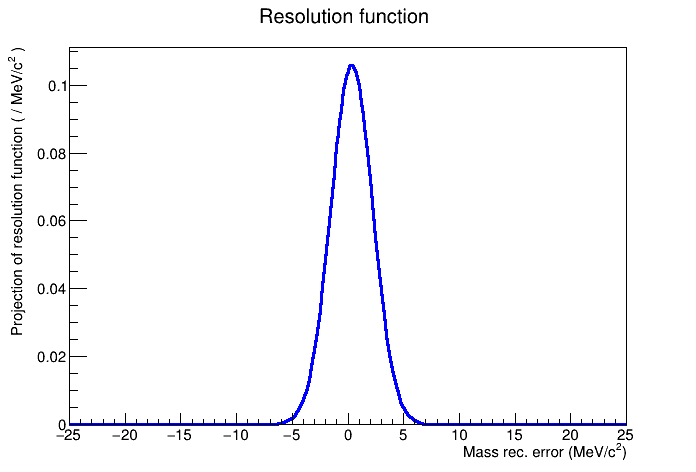

In [8]:
  // resolution function for signal
  // parameters are fixed to values suggested by simulation
  RooRealVar meanbs2st("meanbs2st","mean bs2st", 0.351);
  RooRealVar sigma2("sigma2","sigma2", 1.88396e+00);
  RooRealVar widthbs2st2_mc("widthbs2st2_mc","width of peaks", 2.74736e+01);
  RooRealVar n4("n4","order", 8.04947e-01);

  // just for the plot, define the resolution function as a function of the mass reconstruction error
  RooRealVar Delta("Delta","Mass rec. error",-25, 25,"MeV/c^{2}");
  RooCBShape SigResModel("SigResModel","resolution function", Delta, meanbs2st, sigma2, widthbs2st2_mc, n4);
  
  RooPlot *frameReso = Delta.frame(Title("Resolution function"));
  SigResModel.plotOn(frameReso);
  frameReso->Draw();
  mycanvas->Draw();

In [9]:
  //define resolution function for dm variable  
  RooCBShape sigreso("sigreso","resolution function", dm, meanbs2st, sigma2, widthbs2st2_mc, n4);

  // reconstructed signal: rel. BW convoluted with resolution function
  RooFFTConvPdf bump0("bump0","Signal 0",dm, bw0, sigreso);

[#1] INFO:Caching -- Changing internal binning of variable 'dm' in FFT 'bump0' from 100 to 930 to improve the precision of the numerical FFT. This can be done manually by setting an additional binning named 'cache'.


In [10]:
  // now combine into the total pdf
  // first fit without signal, yield of comb. background is fixed to value
  //   obtained from same-sign candidates
  RooRealVar nbkg("nbkg", "number of comb background events", 30430.133);
  nbkg.setConstant();
  RooRealVar nbkgap("nbkgap", "number of ap background events", 10000, 0, 1e5);
  RooAddPdf model0("model0", "model", RooArgList(pdfss, pdfap), RooArgList(nbkg, nbkgap));

  model0.getParameters(mydata)->Print();

RooArgSet::parameters = (c0,c1,nbkg,nbkgap)


In [11]:
  bool extendedFit=true;
  RooFitResult* fit0=model0.fitTo(mydata, Extended(extendedFit),  Save(true));
  

[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (pdfss)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (pdfap)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 c0          -5.00000e-01  2.00000e-01   -1.00000e+00  1.00000e+00
     2 c1           0.00000e+00  2.00000e-01   -1.00000e+00  1.00000e+00
     3 nbkgap       1.00000e+04  5.00000e+03    0.00000e+00  1.00000e+05
 **********
 **    3 

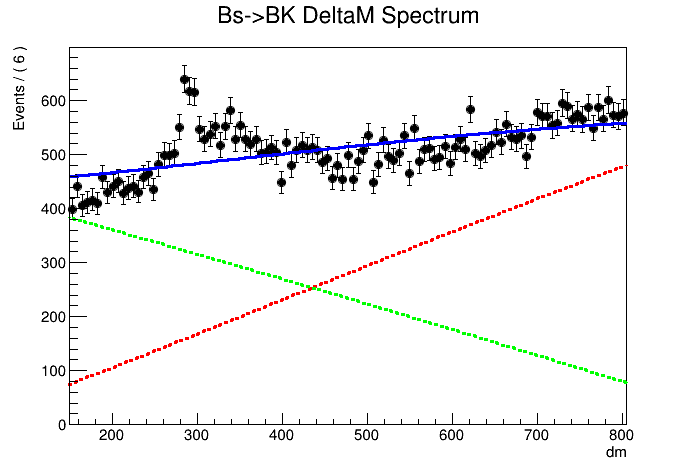

[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model0) directly selected PDF components: (pdfss)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model0) indirectly selected PDF components: ()
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model0) directly selected PDF components: (pdfap)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model0) indirectly selected PDF components: ()
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)


In [12]:
  // plot fitted curve and its components
  model0.plotOn(frame);
  frame->Draw();
  
  model0.plotOn(frame ,Components(pdfss), LineColor(2), LineStyle(2));
  model0.plotOn(frame ,Components(pdfap), LineColor(3), LineStyle(3));
  frame->Draw();
  mycanvas->Draw();

In [13]:
fit0->Print()


  RooFitResult: minimized FCN value: -192606, estimated distance to minimum: 2.12279e-06
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                    c0   -6.5662e-01 +/-  1.79e-02
                    c1   -7.6536e-03 +/-  1.58e-02
                nbkgap    2.5419e+04 +/-  2.36e+02



In [14]:
// compute -2 log(Lik) from the histogram counts to check fit quality 
double mylik(RooAddPdf& model, bool extended=true) {
 // compute -2*log(likelihood) using Poisson(extended) or Multinomial pdf 
  double binw=h->GetBinCenter(2)-h->GetBinCenter(1);
  double my2dll=0;
  for (int i=1; i<=h->GetNbinsX(); i++) {
    dm=h->GetBinCenter(i);
    double mui=model.getVal(dm) * binw * h->Integral();
    double ni= h->GetBinContent(i);
    //Printf("x=%.3f   count=%i mu=%.3f",dm.getVal(), (int) ni, mui );
    my2dll += 2*(ni*log(ni/mui));
    if(extended) my2dll += 2*(mui- ni);
  }
  return my2dll;
}

In [15]:
// generic chi2 test
double chi2Test( double& chi2 , RooFitResult* fit) {
  int ndf=h->GetNbinsX() -  fit->floatParsFinal().size();
  double pvalue=ROOT::Math::chisquared_cdf_c (chi2, ndf);
  Printf("chi2 test for fit quality: chi2=%.2f / %d ndf -> p-value=%.3g",
	 chi2, ndf,
	 ROOT::Math::chisquared_cdf_c (chi2, ndf) );
  return pvalue;
}

In [16]:
  // check overall fit quality
  double my2mll0=mylik(model0);
  chi2Test(my2mll0, fit0);
  

[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
chi2 test for fit quality: chi2=369.18 / 106 ndf -> p-value=8.18e-31


In [17]:
  // fit with one resonance
  RooRealVar nsig0("nsig0", "number of signal events", 100, 0, 2e4);
  RooAddPdf model1("model1", "model1", RooArgList(bump0, pdfss, pdfap), 
                   RooArgList(nsig0, nbkg, nbkgap));
    
  RooFitResult* fit1=model1.fitTo(mydata, Extended(extendedFit),  Save(true));

[#1] INFO:Eval -- RooRealVar::setRange(dm) new range named 'refrange_fft_bump0' created with bounds [150,804]
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw0_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c4f6ff0 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c682ac0 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:Minization --  The following expressions have been ident

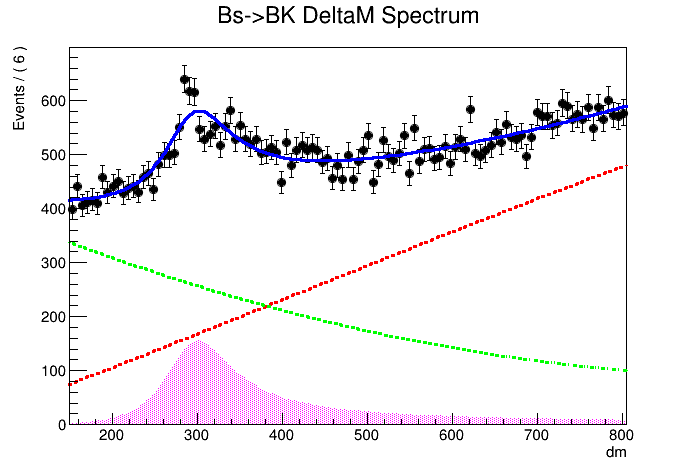

[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw0_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c45c670 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model1) directly selected PDF components: (pdfss)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model1) indirectly selected PDF components: ()
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c52c0c0 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model1) directly selected PDF components: 

In [18]:
  RooPlot *frame1 = dm.frame(Title("Bs->BK DeltaM Spectrum"));
  mydata.plotOn(frame1);
  model1.plotOn(frame1);

  model1.plotOn(frame1 ,Components(pdfss), LineColor(2), LineStyle(2));
  model1.plotOn(frame1 ,Components(pdfap), LineColor(3), LineStyle(3));
  model1.plotOn(frame1 ,Components(bump0), LineColor(6), DrawOption("F"),
                FillStyle(3002), FillColor(6));
  frame1->Draw();
  mycanvas->Draw();

In [19]:
  // compare model0 and model1 using Wilk's theorem
  double my2mll1=mylik(model1);
  double lambda1=my2mll0-my2mll1;
  int ndf=fit1->floatParsFinal().size()-fit0->floatParsFinal().size();
  Printf("chi2 test for model1/model0 significance: chi2=%.2f / %d ndf -> p-value=%.3g",
	 lambda1, ndf,
	 ROOT::Math::chisquared_cdf_c (lambda1, ndf) );

[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c52d090 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
chi2 test for model1/model0 significance: chi2=250.50 / 3 ndf -> p-value=5.11e-54


In [20]:
  // overall fit quality
  chi2Test(my2mll1, fit1);
  

chi2 test for fit quality: chi2=118.68 / 103 ndf -> p-value=0.138


In [21]:
  // alternative: standard chi2 test
  double chi2=(model1.createChi2(mydata))->getVal();
  chi2Test(chi2, fit1);

[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c70f4b0 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
chi2 test for fit quality: chi2=119.05 / 103 ndf -> p-value=0.133


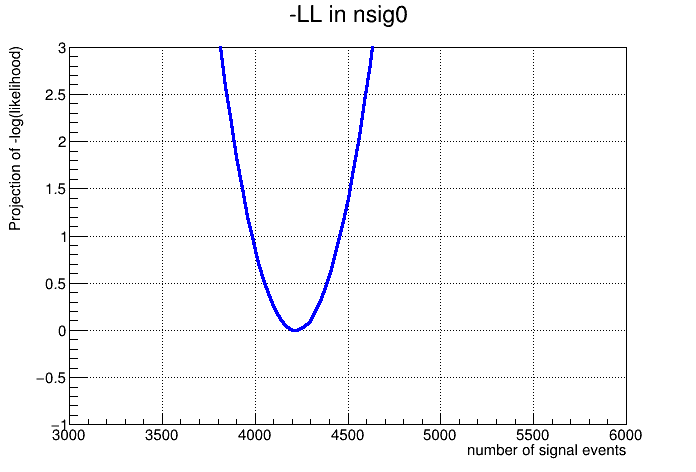

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c6baa60 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c7222c0 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c743c50 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm])

In [22]:
  // now check profile of the -log(likelihood) in nsig,
  // to check how far we are from asymptotic behaviour (parabolic) 
  RooAbsReal *nll1 = model1.createNLL(mydata);
  
  RooPlot *framescan1 = nsig0.frame(Range(3000., 6000.), Title("-LL in nsig0"));
  nll1->plotOn(framescan1, ShiftToZero());
  framescan1->SetMinimum(-1);
  framescan1->SetMaximum(3);
  framescan1->Draw();
  mycanvas->SetGrid();
  mycanvas->Draw();

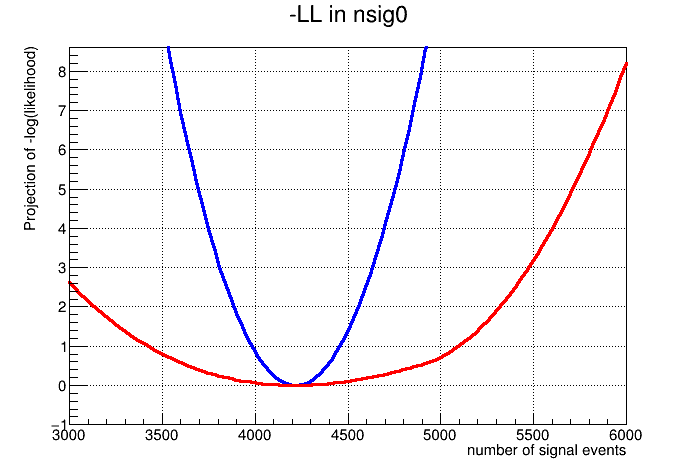

[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c7c0bb0 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model1_data_Profile[nsig0]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model1_data_Profile[nsig0]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c7984e0 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw0_Int[dm]) using numeric integrator RooIn

In [23]:
  // now compute the profile likelihood in nsig0
  RooAbsReal* pnll1 = nll1->createProfile(nsig0) ;
  pnll1->plotOn(framescan1,LineColor(kRed)) ;
  framescan1->Draw();
  mycanvas->Draw();

In [24]:
  // fit with two resonances
  RooRealVar mbump1("mbump1","mbump1", 336, 270, 410);
  RooRealVar wbump1("wbump1","wbump1",70 , 5, 150);
  RooFormulaVar mabs_bump1( "mabs_bump1", "mabs_bump1", "mbump1 + mb + mk", RooArgList( mbump1, mb, mk) );
  RooRelBreitWigner bw1( "bw1", "Breit Wigner 1", mabs, mabs_bump1, wbump1, spin, radius, mb, mk );

  // reconstructed signal: rel. BW convoluted with resolution function
  RooFFTConvPdf bump1("bump1","Signal 1",dm, bw1, sigreso);

  RooRealVar nsig1("nsig1", "number of signal1 events", 100, 0, 2e4);
  RooAddPdf model2("model2", "model2", RooArgList(bump0, bump1, pdfss, pdfap), RooArgList(nsig0, nsig1, nbkg, nbkgap));
    
  RooFitResult* fit2=model2.fitTo(mydata, Extended(extendedFit),  Save(true));


[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c89a5e0 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:Eval -- RooRealVar::setRange(dm) new range named 'refrange_fft_bump1' created with bounds [150,804]
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw1_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump1) creating new cache 0x7f289c6b9f90 with pdf bw1_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating ne

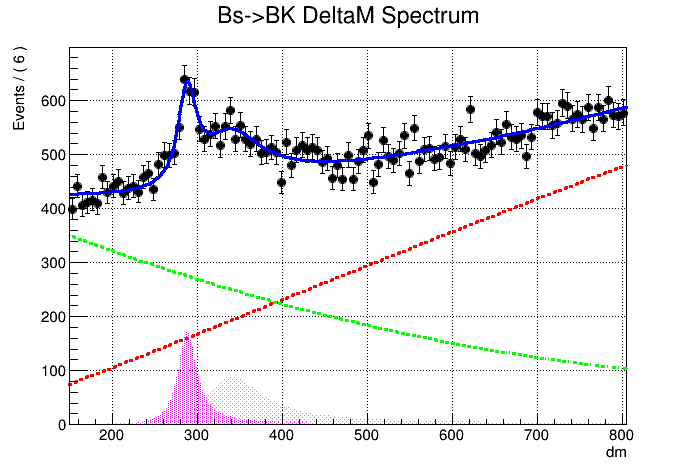

[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw0_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c459e10 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw1_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump1) creating new cache 0x7f289c789150 with pdf bw1_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model2) directly selected PDF components: (pdfss)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model2) indirectly selected PDF components: ()
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c8e33b0 with pdf bw0_CONV_sigr

In [25]:
  RooPlot *frame2 = dm.frame(Title("Bs->BK DeltaM Spectrum"));
  mydata.plotOn(frame2);
  model2.plotOn(frame2);
  frame2->Draw();

  model2.plotOn(frame2 ,Components(pdfss), LineColor(2), LineStyle(2));
  model2.plotOn(frame2 ,Components(pdfap), LineColor(3), LineStyle(3));
  model2.plotOn(frame2 ,Components(bump0), LineColor(6), DrawOption("F"), FillStyle(3002), FillColor(6));
  model2.plotOn(frame2 ,Components(bump1), LineColor(8), DrawOption("F"), FillStyle(3003), FillColor(8));
  frame2->Draw();

  mycanvas->Draw();
 

In [26]:
  double my2mll2=mylik(model2);
  double lambda2=my2mll1-my2mll2;
  ndf=fit2->floatParsFinal().size()-fit1->floatParsFinal().size();
  Printf("chi2 test for model2/model1 significance: chi2=%.2f / %d ndf -> p-value=%.3g",
	 lambda2, ndf,
	 ROOT::Math::chisquared_cdf_c (lambda2, ndf) );
 

[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw0_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump1) creating new cache 0x7f289c8dc180 with pdf bw1_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
chi2 test for model2/model1 significance: chi2=25.07 / 3 ndf -> p-value=1.5e-05


In [27]:
  // overall goodness of fit with -2LL  and chi2
  chi2Test(my2mll2, fit2);
  double chi2=(model2.createChi2(mydata))->getVal();
  chi2Test(chi2, fit2);

chi2 test for fit quality: chi2=93.61 / 100 ndf -> p-value=0.661
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289c79c170 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump1) creating new cache 0x7f289c932e90 with pdf bw1_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
chi2 test for fit quality: chi2=93.66 / 100 ndf -> p-value=0.659


In [28]:
//the 2-resonance fitted model
fit2->Print()


  RooFitResult: minimized FCN value: -192744, estimated distance to minimum: 0.000217705
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter    FinalValue +/-  Error   
  --------------------  --------------------------
                    c0   -5.8706e-01 +/-  2.20e-02
                    c1    8.2911e-02 +/-  2.95e-02
                 mbump    2.8884e+02 +/-  1.72e+00
                mbump1    3.4740e+02 +/-  6.47e+00
                nbkgap    2.2282e+04 +/-  6.37e+02
                 nsig0    1.2237e+03 +/-  3.45e+02
                 nsig1    1.9111e+03 +/-  8.16e+02
                 wbump    2.5989e+01 +/-  7.25e+00
                wbump1    8.8857e+01 +/-  3.91e+01



In [29]:
// fit with three resonances
  RooRealVar mbump2("mbump2","mbump2", 630, 600, 660);
  RooRealVar wbump2("wbump2","wbump2",10. , 5, 150);
  RooFormulaVar mabs_bump2( "mabs_bump2", "mabs_bump2", "mbump2 + mb + mk", RooArgList( mbump2, mb, mk) );
  RooRelBreitWigner bw2( "bw2", "Breit Wigner 2", mabs, mabs_bump2, wbump2, spin, radius, mb, mk );

  // reconstructed signal: rel. BW convoluted with resolution function
  RooFFTConvPdf bump2("bump2","Signal 2",dm, bw2, sigreso);

  RooRealVar nsig2("nsig2", "number of signal2 events", 100, 0, 2e4);
  RooAddPdf model3("model3", "model3", RooArgList(bump0, bump1, bump2, pdfss, pdfap), RooArgList(nsig0, nsig1, nsig2, nbkg, nbkgap));
    
  RooFitResult* fit3=model3.fitTo(mydata, Extended(extendedFit),  Save(true));

[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289ca02bd0 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump1) creating new cache 0x7f289ca48670 with pdf bw1_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
[#1] INFO:Eval -- RooRealVar::setRange(dm) new range named 'refrange_fft_bump2' created with bounds [150,804]
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw2_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump2) creating new cache 0x7f289c9e1750 with pdf bw2_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO

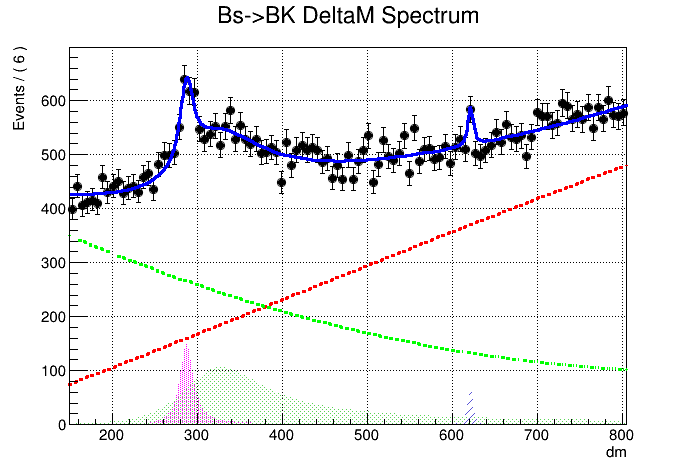

[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw0_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump0) creating new cache 0x7f289ca530b0 with pdf bw0_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw1_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump1) creating new cache 0x7f289c9fbf80 with pdf bw1_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw2_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump2) creating new cache 0x7f289c8529d0 with pdf bw2_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdfss_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(

In [30]:
 RooPlot *frame3 = dm.frame(Title("Bs->BK DeltaM Spectrum"));
 mydata.plotOn(frame3);
 model3.plotOn(frame3);
 model3.plotOn(frame3 ,Components(pdfss), LineColor(2), LineStyle(2));
 model3.plotOn(frame3 ,Components(pdfap), LineColor(3), LineStyle(3));
 model3.plotOn(frame3 ,Components(bump0), LineColor(6), DrawOption("F"), FillStyle(3002), FillColor(6));
 model3.plotOn(frame3 ,Components(bump1), LineColor(8), DrawOption("F"), FillStyle(3003), FillColor(8));
 model3.plotOn(frame3 ,Components(bump2), LineColor(9), DrawOption("F"), FillStyle(3004), FillColor(9));
 frame3->Draw();
 mycanvas->Draw();

In [31]:
double my2mll3=mylik(model3);
double lambda3=my2mll2-my2mll3;
ndf=fit3->floatParsFinal().size()-fit2->floatParsFinal().size();
double pvalue=ROOT::Math::chisquared_cdf_c (lambda3, ndf);
Printf("chi2 test for model3/model2 significance: chi2=%.2f / %d ndf -> p-value=%.3g",
	 lambda3, ndf, pvalue);
Printf("The Signal %s significant at 99%% CL", pvalue<0.01 ? "IS" : "IS NOT");

[#1] INFO:NumericIntegration -- RooRealIntegral::init(bw1_Int[dm]) using numeric integrator RooIntegrator1D to calculate Int(dm)
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(bump2) creating new cache 0x7f289c9683d0 with pdf bw2_CONV_sigreso_CACHE_Obs[dm]_NORM_dm for nset (dm) with code 0 from preexisting content.
chi2 test for model3/model2 significance: chi2=4.55 / 3 ndf -> p-value=0.208
The Signal IS NOT significant at 99% CL
